In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 20 kB/s 
     |████████████████████████████████| 439 kB 66.9 MB/s 
     |████████████████████████████████| 1.7 MB 56.4 MB/s 
     |████████████████████████████████| 6.0 MB 61.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

Text(0.5, 0, 'Diagnosis')

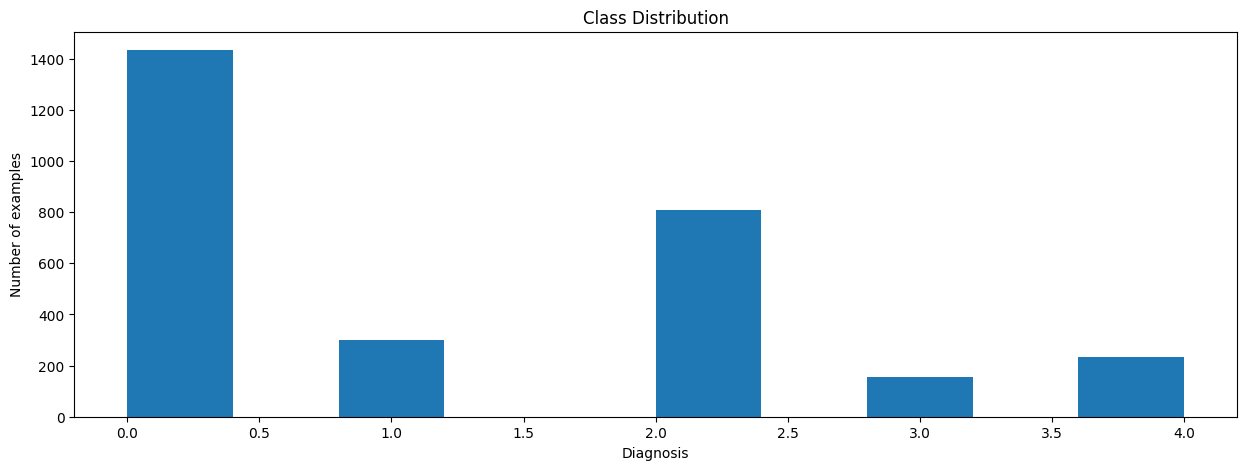

In [ ]:
##### PACKAGES

import numpy as np
import pandas as pd

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset

from PIL import Image, ImageFile
import cv2

import random
import time
import sys
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
%matplotlib inline


##### CLASS DISTRIBUTION

# import data
train = pd.read_csv('/content/drive/MyDrive/train_1.csv')
test  = pd.read_csv('/content/drive/MyDrive/test.csv')

# plot
fig = plt.figure(figsize = (15, 5))
plt.hist(train['diagnosis'])
plt.title('Class Distribution')
plt.ylabel('Number of examples')
plt.xlabel('Diagnosis')

In [ ]:
# import data
train = pd.read_csv('/content/drive/MyDrive/train_1.csv')
train.columns = ['id_code', 'diagnosis']
test = pd.read_csv('/content/drive/MyDrive/test.csv')

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['diagnosis'].value_counts(normalize = True))
print('-' * 15)
print(test['diagnosis'].value_counts(normalize = True))

(2930, 2) (366, 2)
---------------
0    0.489420
2    0.275768
1    0.102389
4    0.079863
3    0.052560
Name: diagnosis, dtype: float64
---------------
0    0.543716
2    0.237705
4    0.090164
1    0.081967
3    0.046448
Name: diagnosis, dtype: float64


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


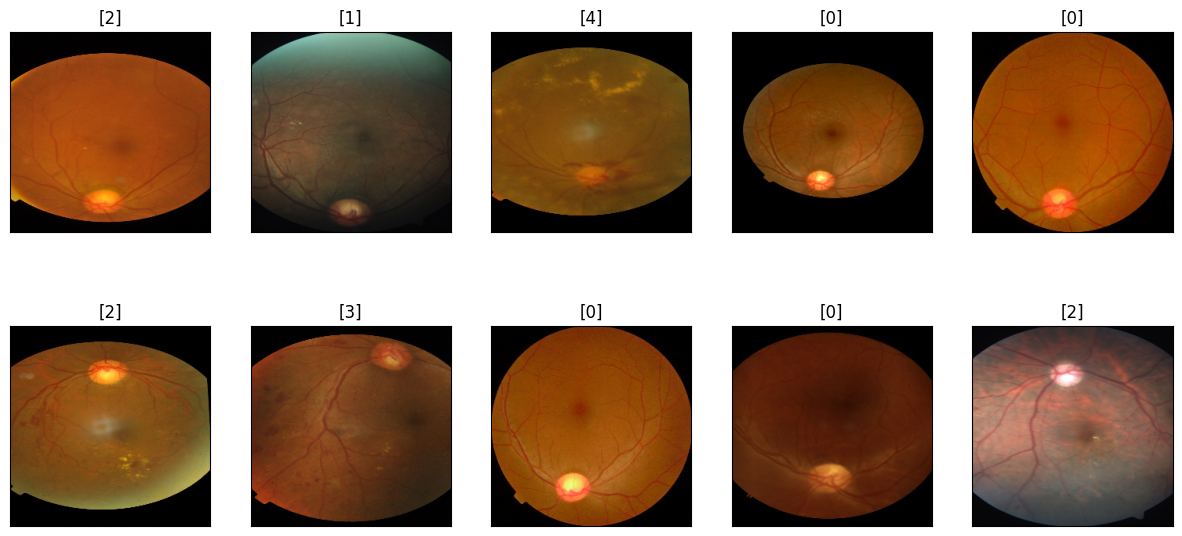

In [ ]:
##### DATASET

# image preprocessing
def prepare_image(path, image_size = 256):

    # import
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # resize
    image = cv2.resize(image, (int(image_size), int(image_size)))

    # convert to tensor
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image

# dataset
class EyeData(Dataset):

    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform

    # length
    def __len__(self):
        return len(self.data)

    # get items
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + '.png')
        image    = prepare_image(img_name)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}


##### EXAMINE SAMPLE BATCH

# transformations
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])

# dataset
sample = EyeData(data       = train,
                 directory  = '/content/drive/MyDrive/train_images',
                 transform  = sample_trans)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample,
                                            batch_size  = 10,
                                            shuffle     = False,
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)

    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)//2, i + 1, xticks = [], yticks = [])
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

In [ ]:
### image preprocessing function
def prepare_image(path, sigmaX = 10, do_random_crop = False):

    # import image
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # perform smart crops
    image = crop_black(image, tol = 7)
    if do_random_crop == True:
        image = random_crop(image, size = (0.9, 1))

    # resize and color
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)

    # circular crop
    image = circle_crop(image)

    # convert to tensor
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image


### automatic crop of black areas
def crop_black(img, tol = 7):

    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]

    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]

        if (check_shape == 0):
            return img
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img  = np.stack([img1, img2, img3], axis = -1)
            return img


### circular crop around center
def circle_crop(img):

    height, width, depth = img.shape

    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness = -1)

    img = cv2.bitwise_and(img, img, mask = circle_img)
    return img


### random crop
def random_crop(img, size = (0.9, 1)):

    height, width, depth = img.shape

    cut = 1 - random.uniform(size[0], size[1])

    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)

    img = img[i:h, j:w, :]

    return img

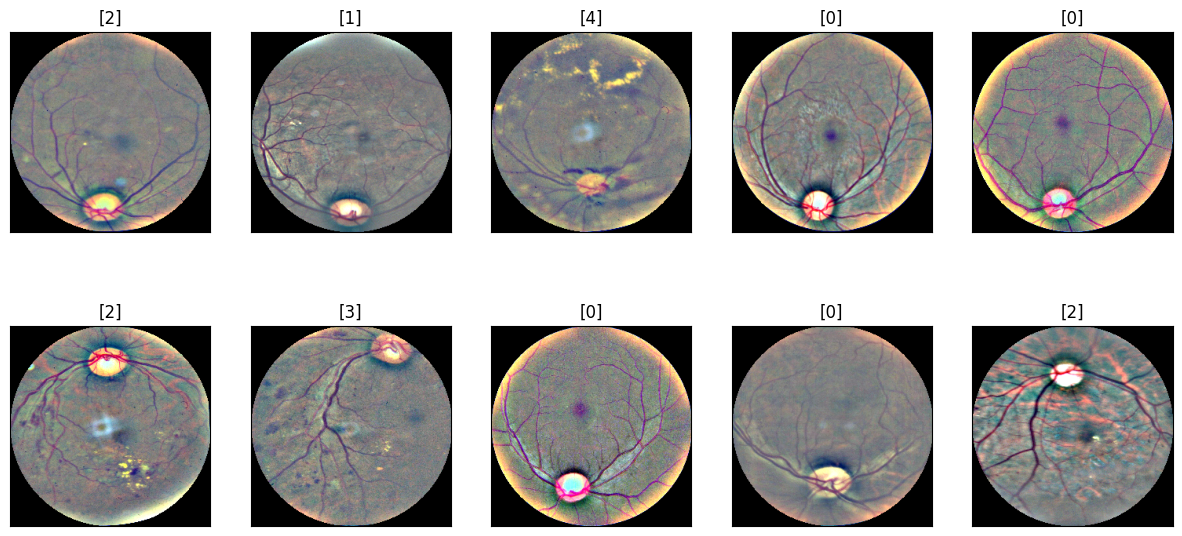

In [ ]:
##### DATASET

# dataset class
class EyeData(Dataset):

    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform

    # length
    def __len__(self):
        return len(self.data)

    # get items
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + '.png')
        image    = prepare_image(img_name)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}


##### EXAMINE SAMPLE BATCH

image_size = 256


# transformations
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])

# dataset
sample = EyeData(data       = train,
                 directory  = '/content/drive/MyDrive/train_images',
                 transform  = sample_trans)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample,
                                            batch_size  = 10,
                                            shuffle     = False,
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)

    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)//2, i + 1, xticks = [], yticks = [])
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

In [ ]:
# GPU check
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
    device = torch.device('cpu')
else:
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda:0')

# set seed
def seed_everything(seed = 23):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed = 23
seed_everything(seed)

CUDA is available. Training on GPU...


In [ ]:
# Train Data Class
class EyeTrainData(Dataset):

    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform

    # length
    def __len__(self):
        return len(self.data)

    # get items
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + '.jpeg')
        image    = prepare_image(img_name, do_random_crop = True)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}


# Testing Data Class
class EyeTestData(Dataset):

    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform

    # length
    def __len__(self):
        return len(self.data)

    # get items
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + '.png')
        image    = prepare_image(img_name, do_random_crop = False)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}

In [ ]:


# parameters
batch_size = 20
image_size = 256

# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])

# validation transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])

# create datasets
train_dataset = EyeTrainData(data      = train,
                             directory = '/content/drive/MyDrive/train_images',
                             transform = train_trans)
valid_dataset = EyeTestData(data       = test,
                            directory  = '/content/drive/MyDrive/valid_images',
                            transform  = valid_trans)

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size  = batch_size,
                                           shuffle     = True,
                                           num_workers = 4)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size  = batch_size,
                                           shuffle     = False,
                                           num_workers = 4)

In [ ]:
!pip install efficientnet_pytorch -q
import torch.nn as nn
import efficientnet_pytorch as efn

  Preparing metadata (setup.py) ... done


In [ ]:

# model name
model_name = 'efficientnet-b4'

# initialization function
def init_model(train = True):

    ### training mode
    if train == True:

        # load pre-trained model
        model = efn.EfficientNet.from_pretrained(model_name, num_classes = 5)
        # model = models.efficientnet_b4(pretrained = True)

    ### inference mode
    if train == False:

        # load pre-trained model
        model = efn.EfficientNet.from_name(model_name)
        model._fc = nn.Linear(model._fc.in_features, 5)

        # freeze  layers
        for param in model.parameters():
            param.requires_grad = False

    return model


# print architecture
model = init_model()
print(model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 111MB/s]


Loaded pretrained weights for efficientnet-b4
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, ke

In [ ]:
loss_fun = 'categorical_crossentropy'
k = 5
image_size = 512
classes = 5

base_model = Model('densenet121',image_size)
base_in = model.input
base_out = model.output

x = Global_attention_block(base_out)
base_out = Category_attention_block(x, classes, k)

x = GlobalAveragePooling2D()(base_out)
out = Dense(classes,activation='softmax')(x)

model = Model(model.input,out)
model.summary()


29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
# no. folds
num_folds = 4

# creating splits
skf    = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = seed)
splits = list(skf.split(train['id_code'], train['diagnosis']))

# placeholders
oof_preds = np.zeros((len(train), 1))

# timer
cv_start = time.time()


##### PARAMETERS

# loss function
criterion = nn.CrossEntropyLoss()

# epochs
max_epochs = 15
early_stop = 5

# learning rates
eta = 1e-3

# scheduler
step  = 5
gamma = 0.5

# optimizer
optimizer = optim.Adam(model.parameters(), lr = eta)
scheduler = lr_scheduler.StepLR(optimizer, step_size = step, gamma = gamma)

# initialize model and send to GPU
model = init_model()
model = model.to(device)

for fold in tqdm(range(num_folds)):

    ####### DATA PREPARATION

    # display information
    print('-' * 30)
    print('FOLD {}/{}'.format(fold + 1, num_folds))
    print('-' * 30)

    # load splits
    data_train = train.iloc[splits[fold][0]].reset_index(drop = True)
    data_valid = train.iloc[splits[fold][1]].reset_index(drop = True)

    # create datasets
    train_dataset = EyeTrainData(data      = data_train,
                                 directory = '../input/aptos2019-blindness-detection/train_images',
                                 transform = train_trans)
    valid_dataset = EyeTrainData(data      = data_valid,
                                 directory = '../input/aptos2019-blindness-detection/valid_images',
                                 transform = valid_trans)

    # create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size  = batch_size,
                                               shuffle     = True,
                                               num_workers = 4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size  = batch_size,
                                               shuffle     = False,
                                               num_workers = 4)


    ####### MODEL PREPARATION

    # placeholders
    val_kappas = []
    val_losses = []
    trn_losses = []
    bad_epochs = 0

    # load best OOF predictions
    if fold > 0:
        oof_preds = oof_preds_best.copy()

    # initialize and send to GPU
    model = init_model(train = True)
    model = model.to(device)

    # optimizer
    optimizer = optim.Adam(model._fc.parameters(), lr = eta)
    scheduler = lr_scheduler.StepLR(optimizer, step_size = step, gamma = gamma)


    ####### TRAINING AND VALIDATION LOOP
    for epoch in range(max_epochs):

        ##### PREPARATION

        # timer
        epoch_start = time.time()

        # reset losses
        trn_loss = 0.0
        val_loss = 0.0

        # placeholders
        fold_preds = np.zeros((len(data_valid), 1))


        ##### TRAINING

        # switch regime
        model.train()

        # loop through batches
        for batch_i, data in enumerate(train_loader):

            # extract inputs and labels
            inputs = data['image']
            labels = data['label'].view(-1)
            inputs = inputs.to(device, dtype = torch.float)
            labels = labels.to(device, dtype = torch.long)
            optimizer.zero_grad()

            # forward and backward pass
            with torch.set_grad_enabled(True):
                preds = model(inputs)
                loss  = criterion(preds, labels)
                loss.backward()
                optimizer.step()

            # compute loss
            trn_loss += loss.item() * inputs.size(0)


        ##### INFERENCE

        # initialize
        model.eval()

        # loop through batches
        for batch_i, data in enumerate(valid_loader):

            # extract inputs and labels
            inputs = data['image']
            labels = data['label'].view(-1)
            inputs = inputs.to(device, dtype = torch.float)
            labels = labels.to(device, dtype = torch.long)

            # compute predictions
            with torch.set_grad_enabled(False):
                preds = model(inputs).detach()
                _, class_preds = preds.topk(1)
                fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = class_preds.cpu().numpy()

            # compute loss
            loss      = criterion(preds, labels)
            val_loss += loss.item() * inputs.size(0)

        # save predictions
        oof_preds[splits[fold][1]] = fold_preds

        # scheduler step
        scheduler.step()


        ##### EVALUATION

        # evaluate performance
        fold_preds_round = fold_preds
        val_kappa = metrics.cohen_kappa_score(data_valid['diagnosis'], fold_preds_round.astype('int'), weights = 'quadratic')

        # save perfoirmance values
        val_kappas.append(val_kappa)
        val_losses.append(val_loss / len(data_valid))
        trn_losses.append(trn_loss / len(data_train))


        ##### EARLY STOPPING

        # display info
        print('- epoch {}/{} | lr = {} | trn_loss = {:.4f} | val_loss = {:.4f} | val_kappa = {:.4f} | {:.2f} min'.format(
            epoch + 1, max_epochs, scheduler.get_lr()[len(scheduler.get_lr()) - 1],
            trn_loss / len(data_train), val_loss / len(data_valid), val_kappa,
            (time.time() - epoch_start) / 60))

        # check if there is any improvement
        if epoch > 0:
            if val_kappas[epoch] < val_kappas[epoch - bad_epochs - 1]:
                bad_epochs += 1
            else:
                bad_epochs = 0

        # save model weights if improvement
        if bad_epochs == 0:
            oof_preds_best = oof_preds.copy()
            torch.save(model.state_dict(), '../models/model_{}_fold{}.bin'.format(model_name, fold + 1))

        # break if early stop
        if bad_epochs == early_stop:
            print('Early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
                np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
            print('')
            break

        # break if max epochs
        if epoch == (max_epochs - 1):
            print('Did not meet early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
                np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
            print('')
            break

# load best predictions
oof_preds = oof_preds_best

# print performance
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

------------------------------
FOLD 1/4
------------------------------
Loaded pretrained weights for efficientnet-b4
- epoch 1/15 | lr = 0.001 | trn_loss = 0.6279 | val_loss = 0.5368 | val_kappa = 0.8725 | 7.30 min
- epoch 2/15 | lr = 0.001 | trn_loss = 0.5699 | val_loss = 0.5402 | val_kappa = 0.8662 | 7.25 min
- epoch 3/15 | lr = 0.001 | trn_loss = 0.5572 | val_loss = 0.5380 | val_kappa = 0.8631 | 7.31 min
- epoch 4/15 | lr = 0.001 | trn_loss = 0.5482 | val_loss = 0.5357 | val_kappa = 0.8590 | 7.29 min
- epoch 5/15 | lr = 0.00025 | trn_loss = 0.5658 | val_loss = 0.5357 | val_kappa = 0.8613 | 7.25 min
- epoch 6/15 | lr = 0.0005 | trn_loss = 0.5537 | val_loss = 0.5346 | val_kappa = 0.8604 | 7.28 min
Early stopping. Best results: loss = 0.5346, kappa = 0.8604 (epoch 6)

------------------------------
FOLD 2/4
------------------------------
Loaded pretrained weights for efficientnet-b4
- epoch 1/15 | lr = 0.001 | trn_loss = 0.6535 | val_loss = 0.5295 | val_kappa = 0.8767 | 7.24 min
- epoc

In [ ]:
# construct confusion matrx
oof_preds_round = oof_preds.copy()
cm = confusion_matrix(train['diagnosis'], oof_preds_round)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(cm, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_aspect('equal')


![](https://github.com/kozodoi/website/blob/master/_notebooks/images/fig_cm_fine_tuning.png?raw=1)

---------------------------------------------
PREDICTIONS
---------------------------------------------
     0    1    2    3
0  2.0  2.0  2.0  1.5
1  2.0  2.5  2.0  2.0
2  2.0  2.0  2.0  2.0
3  2.0  3.0  2.0  2.0
4  2.0  2.0  2.0  2.0
---------------------------------------------
CORRELATION MATRIX
---------------------------------------------
        0       1       2       3
0  1.0000  0.9624  0.9573  0.9534
1  0.9624  1.0000  0.9686  0.9490
2  0.9573  0.9686  1.0000  0.9478
3  0.9534  0.9490  0.9478  1.0000
Mean correlation = 0.9673
---------------------------------------------
SUMMARY STATS
---------------------------------------------
               0          1          2          3
count  1928.0000  1928.0000  1928.0000  1928.0000
mean      1.6867     1.7103     1.7152     1.6501
std       0.9727     0.9730     0.9704     0.9606
min       0.0000     0.0000     0.0000     0.0000
25%       1.5000     2.0000     2.0000     1.3750
50%       2.0000     2.0000     2.0000     2.0000
7

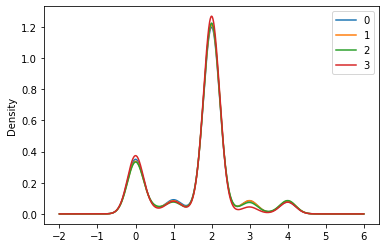

In [ ]:

# show predictions
print('-' * 45)
print('PREDICTIONS')
print('-' * 45)
print(test_preds_df.head())

# show correlation
print('-' * 45)
print('CORRELATION MATRIX')
print('-' * 45)
print(np.round(test_preds_df.corr(), 4))
print('Mean correlation = ' + str(np.round(np.mean(np.mean(test_preds_df.corr())), 4)))

# show stats
print('-' * 45)
print('SUMMARY STATS')
print('-' * 45)
print(test_preds_df.describe())

# show prediction distribution
print('-' * 45)
print('ROUNDED PREDICTIONS')
print('-' * 45)
for f in range(num_folds):
    print(np.round(test_preds_df[f]).astype('int').value_counts(normalize = True))
    print('-' * 45)

# plot densities
test_preds_df.plot.kde()